In [1]:
import matplotlib.pyplot as plt
import cv2
import os, glob
import numpy as np
from moviepy.editor import VideoFileClip

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

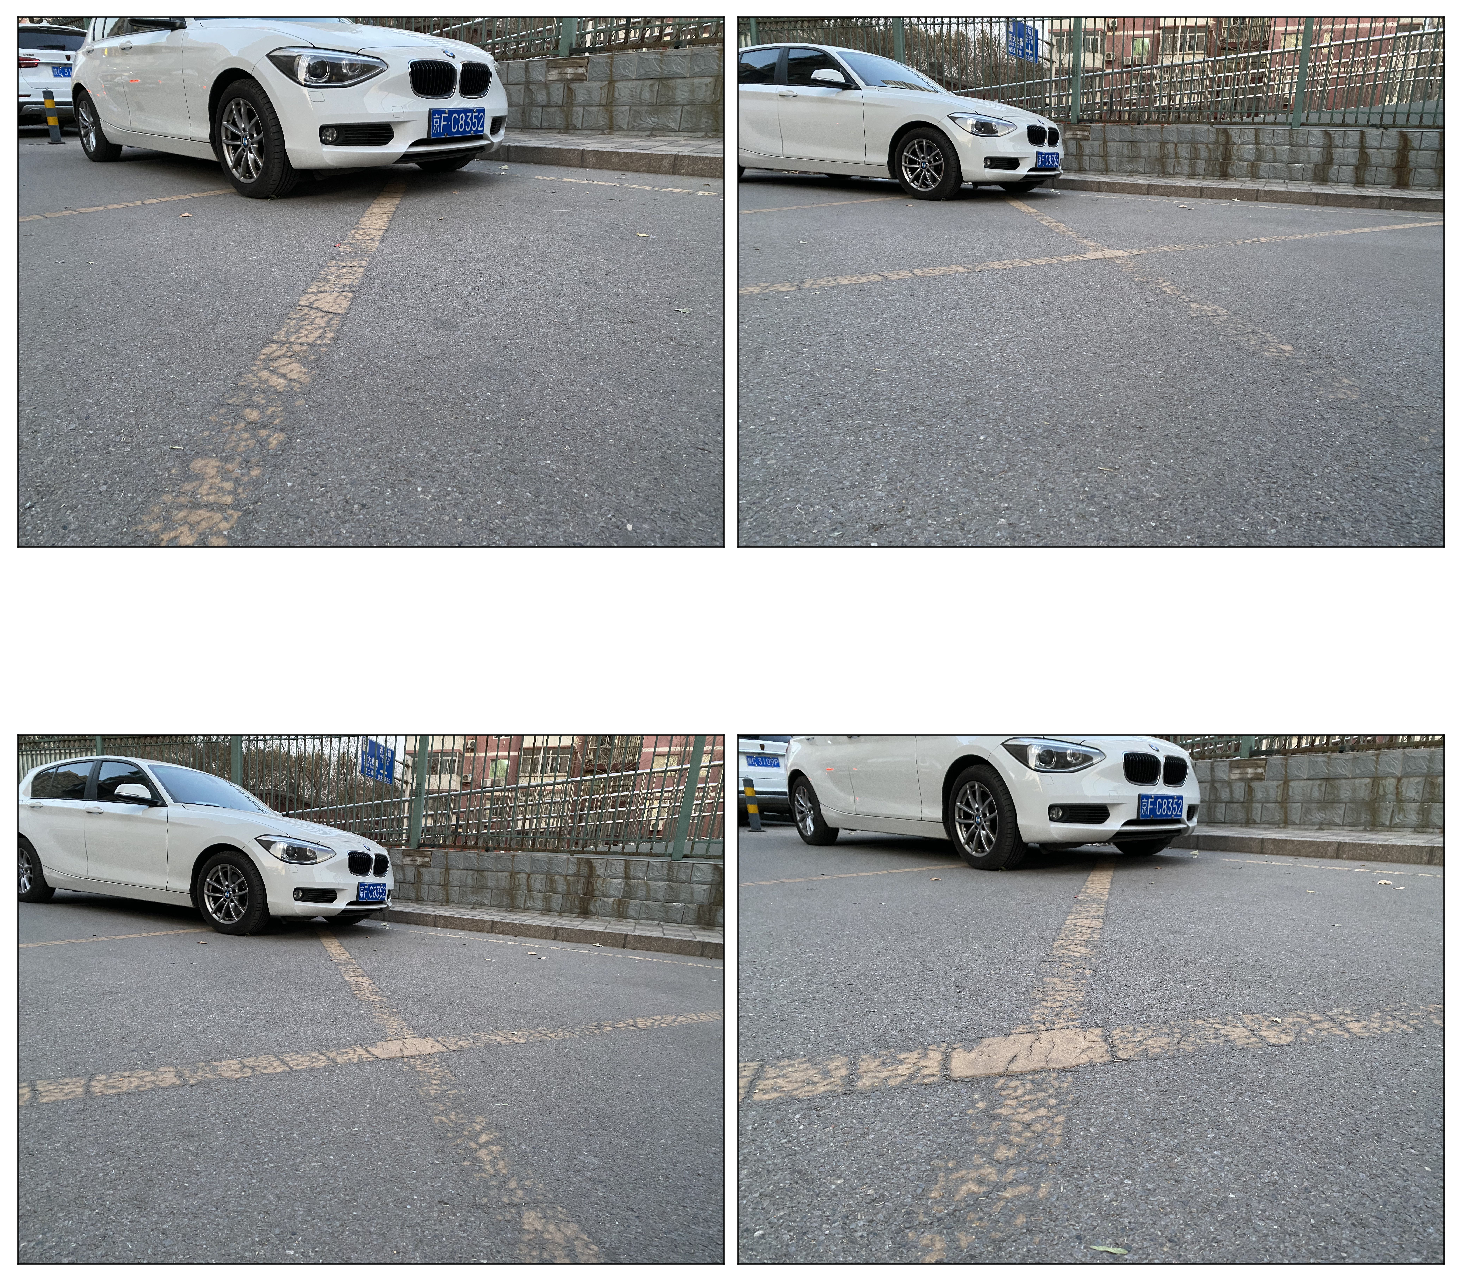

In [3]:
test_images = [plt.imread(path) for path in glob.glob('视频抽帧/*.jpg')]          #图片来源

show_images(test_images)

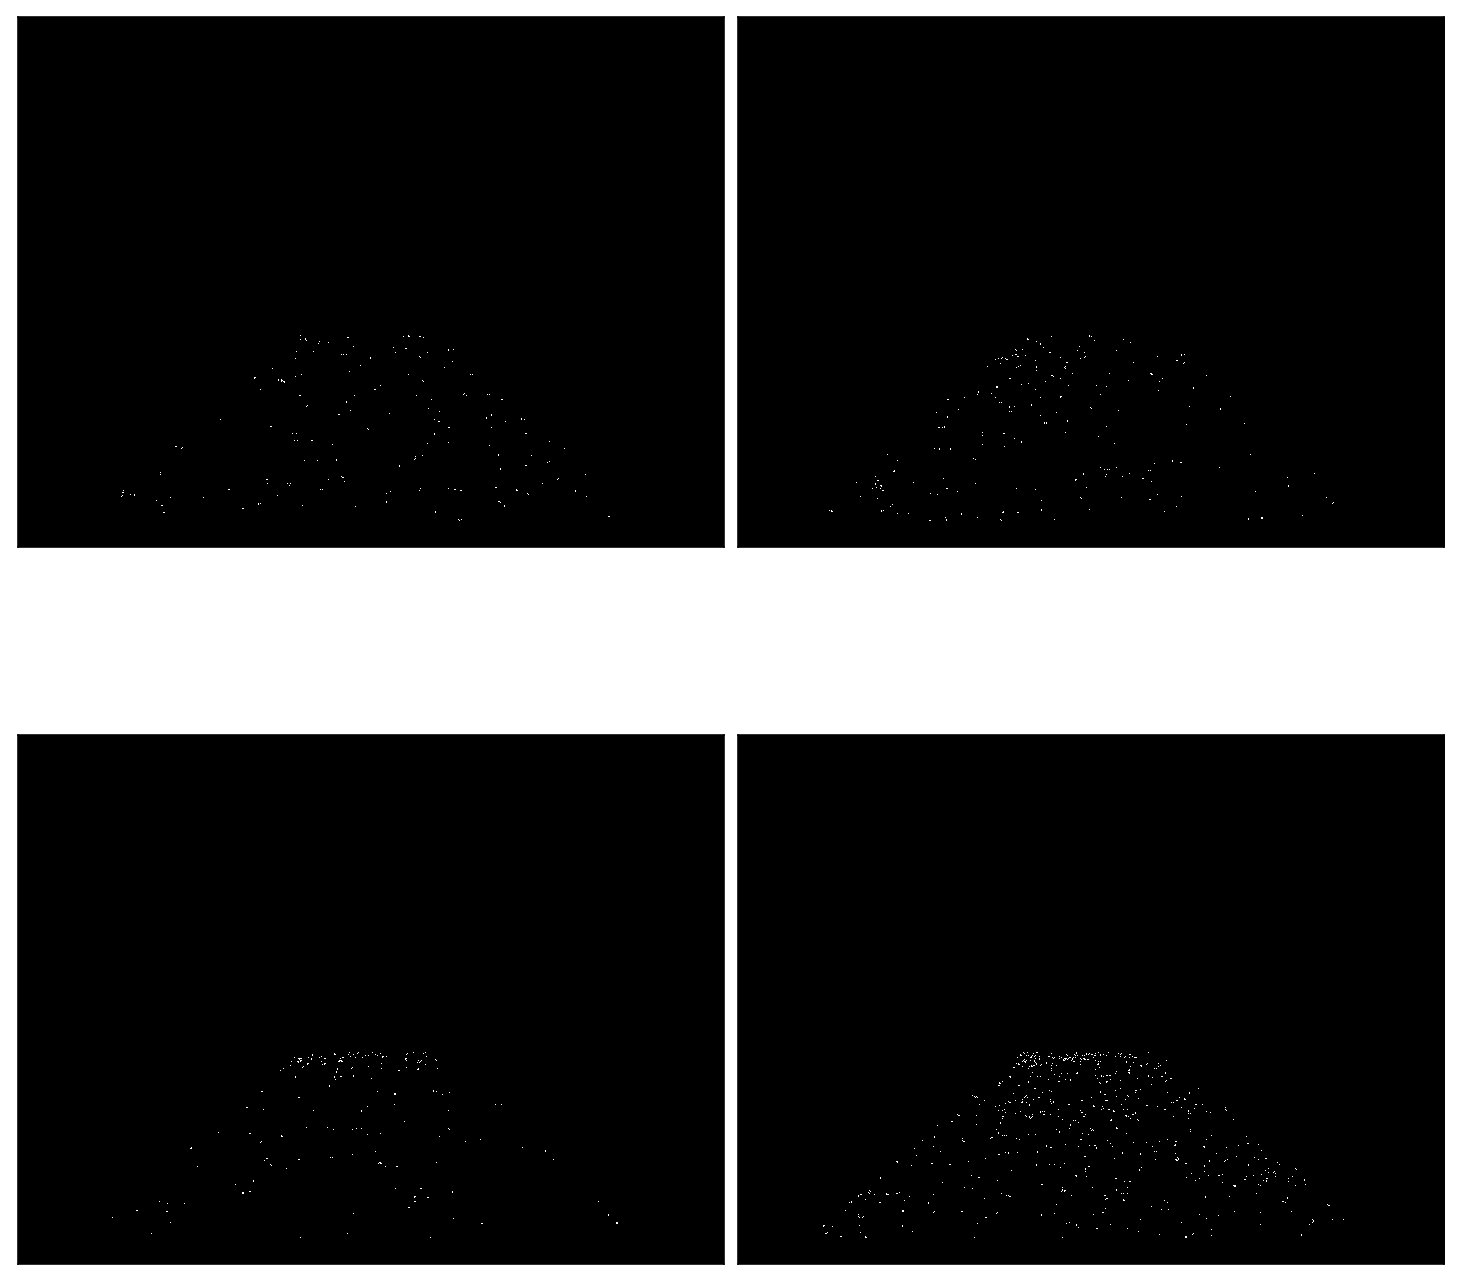

In [4]:
def convert_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

#将目标更加清晰化
def select_white_yellow(image):
    converted = convert_hls(image)
    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = mask)

white_yellow_images = list(map(select_white_yellow, test_images))
#show_images(white_yellow_images)


def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images = list(map(convert_gray_scale, white_yellow_images))


def apply_smoothing(image, kernel_size=15):
    """
    kernel_size must be postivie and odd
    """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
blurred_images = list(map(lambda image: apply_smoothing(image), gray_images))

#将图中所有目标的轮廓都勾出来
def detect_edges(image, low_threshold=50, high_threshold=150):
    return cv2.Canny(image, low_threshold, high_threshold)
edge_images = list(map(lambda image: detect_edges(image), blurred_images))
#show_images(edge_images)

#创建遮罩
def filter_region(image, vertices):
    """
    Create the mask using the vertices and apply it to the input image
    """
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension        
    return cv2.bitwise_and(image, mask)

    
def select_region(image):
    """
    It keeps the region surrounded by the `vertices` (i.e. polygon).  Other area is set to 0 (black).
    """
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.1, rows*0.95]
    top_left     = [cols*0.4, rows*0.6]
    bottom_right = [cols*0.9, rows*0.95]
    top_right    = [cols*0.6, rows*0.6] 
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return filter_region(image, vertices)

# images showing the region of interest only
roi_images = list(map(select_region, edge_images))
show_images(roi_images)
